In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [5]:
#discriminator model
discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape= (28,28,1)),
        tf.keras.layers.Conv2D(6,5,padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size= (2,2),strides= (2,2)),
        tf.keras.layers.Conv2D(16,5,padding='valid'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size= (2,2), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ]
)

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

In [6]:
# Generator model
noise_dim = 200
generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(noise_dim,)),
        tf.keras.layers.Dense(5*5*16, activation = 'relu'),
        tf.keras.layers.Reshape((5,5,16)),
        tf.keras.layers.UpSampling2D(size = (2,2)),
        tf.keras.layers.Conv2D(16,5, padding = 'same',activation = 'relu'),
        tf.keras.layers.Conv2DTranspose(6,5,activation = 'relu'),
        tf.keras.layers.UpSampling2D(size = (2,2)),
        tf.keras.layers.Conv2D(1,5,padding= 'same',),
        tf.keras.layers.ReLU(max_value = 255)
    ]
)
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 400)               80400     
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 16)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 16)        6416      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 6)         2406      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)        

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'digit_data',
    label_mode = None,
    batch_size = 60,
    shuffle = True,
    image_size = (28,28),
    color_mode='grayscale'
)
dataset = dataset.map(lambda x : x/255)

Found 42000 files belonging to 1 classes.


In [8]:
# optimizers for the generator and discriminator

opt_gen = tf.keras.optimizers.Adam(lr = 0.0001)
opt_disc = tf.keras.optimizers.Adam(lr = 0.0001)

# loss funtion

loss = tf.keras.losses.BinaryCrossentropy()



In [22]:
for epoch in range(50,75):
    for idx, real in enumerate(dataset):
        batch_size = real.shape[0]
        random_latent_space = tf.random.normal(shape = (batch_size, noise_dim))

        fake = generator(random_latent_space)

        if idx % 50 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f'generated_images/gen{epoch}_{idx}.jpg')

        #training the discriminator 
        with tf.GradientTape() as disc_tape:
            loss_real = loss(tf.ones((batch_size,1)),discriminator(real))
            loss_fake = loss(tf.zeros((batch_size,1)),discriminator(fake))
            loss_disc = tf.add(loss_real,loss_fake)

        grads = disc_tape.gradient(loss_disc,discriminator.trainable_weights) 
        opt_disc.apply_gradients(zip(grads, discriminator.trainable_weights))

        # training the generator
        #for epoch_gen in range(2):
        with tf.GradientTape() as gen_tape:
            fake = generator(random_latent_space)
            loss_gen = loss(tf.ones((batch_size,1)),discriminator(fake))

        grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
        opt_gen.apply_gradients(zip(grads,generator.trainable_weights))




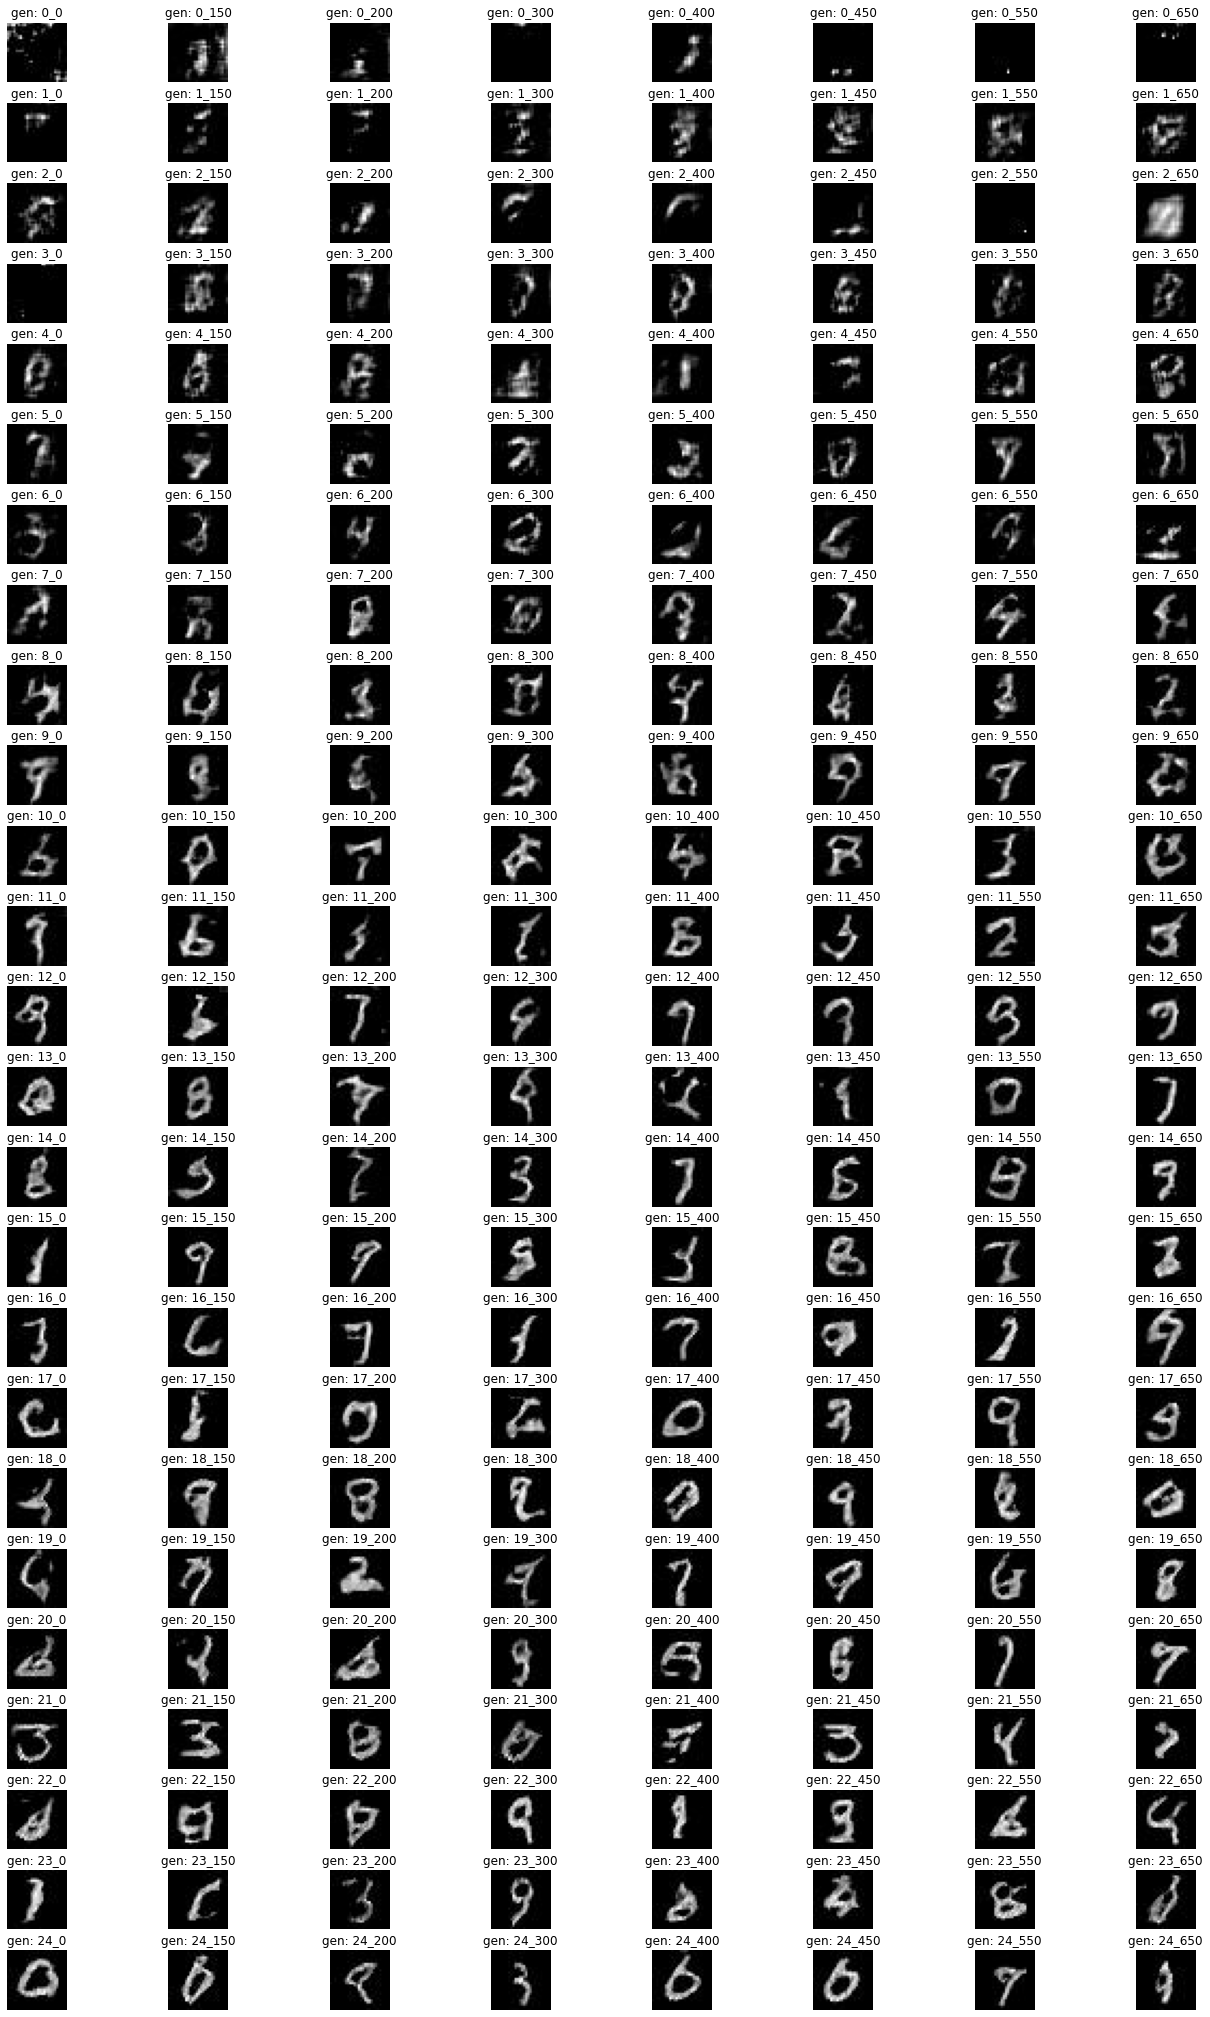

In [13]:
import os
from PIL.Image import fromarray
fig = plt.figure()
count = 0
for i in range(25):
    for j in [0,150,200,300,400,450,550,650]:
        count = count + 1
        img = cv2.imread('generated_images\gen{}_{}.jpg'.format(i,j))
        img = fromarray(img)
        alt = fig.add_subplot(25,8,count)
        alt.axis('off')
        alt.set_title('gen: {}_{}'.format(i,j))
        alt.imshow(img)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=3, 
                    top=7, 
                    wspace=0.3, 
                    hspace=0.35)


In [18]:
# training the models with wloss
wl_discriminator = tf.keras.models.clone_model(discriminator)
wl_discriminator.pop()
wl_discriminator.add(tf.keras.layers.Dense(1,))
wl_discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

In [19]:
wl_generator = tf.keras.models.clone_model(generator)

In [20]:
# optimizers for the generator and discriminator

opt_gen = tf.keras.optimizers.Adam(lr = 0.0001)
opt_disc = tf.keras.optimizers.Adam(lr = 0.0001)

# loss
class wloss(tf.keras.losses.Loss):

    def __init__(self, from_logits=False,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='wloss'):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        ce = tf.reduce_mean(y_true*y_pred)
        return ce
loss = wloss()


In [21]:
for epoch in range(50):
    for idx, real in enumerate(dataset):
        batch_size = real.shape[0]
        random_latent_space = tf.random.normal(shape = (batch_size, noise_dim))

        fake = wl_generator(random_latent_space)

        if idx % 50 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f'wloss_generated_images/gen{epoch}_{idx}.jpg')

        #training the discriminator 
        with tf.GradientTape() as disc_tape:
            loss_real = loss(-tf.ones((batch_size,1)),wl_discriminator(real))
            loss_fake = loss(tf.ones((batch_size,1)),wl_discriminator(fake))
            loss_disc = tf.add(loss_real,loss_fake)

        grads = disc_tape.gradient(loss_disc,wl_discriminator.trainable_weights) 
        opt_disc.apply_gradients(zip(grads, wl_discriminator.trainable_weights))

        # training the generator
        #for epoch_gen in range(2):
        with tf.GradientTape() as gen_tape:
            fake = wl_generator(random_latent_space)
            loss_gen = loss(-tf.ones((batch_size,1)),wl_discriminator(fake))

        grads = gen_tape.gradient(loss_gen, wl_generator.trainable_weights)
        opt_gen.apply_gradients(zip(grads,wl_generator.trainable_weights))

In [2]:
# the generator is able to produce good digits but it still spills garbage now and then for few random generated noises, for it to learn the models were trained longer and wloss was also considered, it is estimated that the model is shallow for the generator to be able to generate consistent real looking digit images  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# taking the networks littles deeper
# critic model
critic = tf.keras.Sequential(
    [
        tf.keras.Input(shape= (28,28,1)),
        tf.keras.layers.Conv2D(20,5,padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size= (2,2),strides= (2,2)),
        tf.keras.layers.Conv2D(50,5,padding='valid'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size= (2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(100,5,padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation= 'sigmoid' )
    ]
)
critic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 50)        25050     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 10, 10, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 100)         1

In [3]:
noise_dim = 250
d_generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(noise_dim,)),
        tf.keras.layers.Dense(5*5*16, activation = 'relu'),
        tf.keras.layers.Reshape((5,5,16)),
        tf.keras.layers.UpSampling2D(size = (2,2)),
        tf.keras.layers.Conv2D(100,5, padding = 'same',activation = 'relu'),
        tf.keras.layers.Conv2DTranspose(50,5,activation = 'relu'),
        tf.keras.layers.UpSampling2D(size = (2,2)),
        tf.keras.layers.Conv2D(20,5,padding= 'same',),
        tf.keras.layers.Conv2D(1,5,padding= 'same',),
        tf.keras.layers.ReLU(max_value = 255)
    ]
)
d_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               100400    
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 16)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 100)       40100     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 50)        125050    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 50)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 20)       

In [4]:
opt_gen = tf.keras.optimizers.Adam(lr = 0.0001)
opt_critic = tf.keras.optimizers.Adam(lr = 0.0001)

# loss
class wloss(tf.keras.losses.Loss):

    def __init__(self, from_logits=False,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='wloss'):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        ce = tf.reduce_mean(y_true*y_pred)
        return ce
loss = tf.keras.losses.BinaryCrossentropy()

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'digit_data',
    label_mode = None,
    batch_size = 60,
    shuffle = True,
    image_size = (28,28),
    color_mode='grayscale'
)
dataset = dataset.map(lambda x : x/255)

Found 42000 files belonging to 1 classes.


In [6]:
for epoch in range(50):
    for idx, real in enumerate(dataset):
        batch_size = real.shape[0]
        random_latent_space = tf.random.normal(shape = (batch_size, noise_dim))

        fake = d_generator(random_latent_space)

        if idx % 50 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f'deep_generation/gen{epoch}_{idx}.jpg')

        #training the discriminator 
        with tf.GradientTape() as disc_tape:
            loss_real = loss(tf.ones((batch_size,1)),critic(real))
            loss_fake = loss(tf.zeros((batch_size,1)),critic(fake))
            loss_critic = tf.add(loss_real,loss_fake)

        grads = disc_tape.gradient(loss_critic,critic.trainable_weights) 
        opt_critic.apply_gradients(zip(grads, critic.trainable_weights))

        # training the generator
        #for epoch_gen in range(2):
        with tf.GradientTape() as gen_tape:
            fake = d_generator(random_latent_space)
            loss_gen = loss(tf.ones((batch_size,1)),critic(fake))

        grads = gen_tape.gradient(loss_gen, d_generator.trainable_weights)
        opt_gen.apply_gradients(zip(grads,d_generator.trainable_weights))

In [ ]:
# trying wloss on deeper network

In [3]:
critic = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape= (28,28,1)),
        tf.keras.layers.Conv2D(20,5,padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size= (2,2),strides= (2,2)),
        tf.keras.layers.Conv2D(50,5,padding='valid'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size= (2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(100,5,padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, )
    ]
)
critic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 50)        25050     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 10, 10, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 100)         1

In [4]:
noise_dim = 150
d_generator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape= (noise_dim,)),
        tf.keras.layers.Dense(5*5*16, activation = 'relu'),
        tf.keras.layers.Reshape((5,5,16)),
        tf.keras.layers.UpSampling2D(size = (2,2)),
        tf.keras.layers.Conv2D(100,5, padding = 'same',activation = 'relu'),
        tf.keras.layers.Conv2DTranspose(50,5,activation = 'relu'),
        tf.keras.layers.UpSampling2D(size = (2,2)),
        tf.keras.layers.Conv2D(20,5,padding= 'same',),
        tf.keras.layers.Conv2D(1,5,padding= 'same',),
        tf.keras.layers.ReLU()
    ]
)
d_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               60400     
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 16)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 100)       40100     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 50)        125050    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 50)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 20)       

In [5]:
opt_gen = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
opt_critic = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)

# loss
class wloss(tf.keras.losses.Loss):

    def __init__(self, from_logits=False,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='wloss'):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        ce = tf.reduce_mean(y_true*y_pred)
        return ce
loss = wloss()

In [7]:
for epoch in range(15,20):
    for idx, real in enumerate(dataset):
        batch_size = real.shape[0]
        random_latent_space = tf.random.normal(shape = (batch_size, noise_dim))

        fake = d_generator(random_latent_space)

        if idx % 10 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f'wl_deep_generation/gen{epoch}_{idx}.jpg')

        #training the discriminator 
        with tf.GradientTape() as disc_tape:
            loss_real = -tf.reduce_mean(critic(real))
            loss_fake = tf.reduce_mean(critic(fake))
            loss_critic = tf.add(loss_real,loss_fake)

            grads = disc_tape.gradient(loss_critic,critic.trainable_weights) 
            opt_critic.apply_gradients(zip(grads, critic.trainable_weights))

        # training the generator
        #for epoch_gen in range(2):
        with tf.GradientTape() as gen_tape:
            fake = d_generator(random_latent_space)
            loss_gen = -tf.reduce_mean(critic(fake))

        grads = gen_tape.gradient(loss_gen, d_generator.trainable_weights)
        opt_gen.apply_gradients(zip(grads,d_generator.trainable_weights))

In [21]:
!git commit -am changes

[main 1982ca0] changes
 1 file changed, 10 insertions(+), 10 deletions(-)
The file will have its original line endings in your working directory


In [22]:
!git push

To https://github.com/sulaiman01/digits_GAN.git
   58de430..1982ca0  main -> main
